#### 4-1 割引クーポンキャンペーンの効果最大化

1. 各会員にどのパターンのダイレクトメールを送付するか
2. 各会員に対し送付するパターンは1つ
3. クーポン付与により来客増加数を最大化
4. 予算100万円以下
5. それぞれのセグメント会員の10%に送付

In [27]:
from pulp import LpProblem, LpVariable, LpMaximize, LpStatus, lpSum
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import math
import seaborn as sns

In [3]:
files = glob('../*/*coupon/*.csv')
customers_df = pd.read_csv(files[0])
visit_probability_df = pd.read_csv(files[1])

In [5]:
customers_df.head()

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0


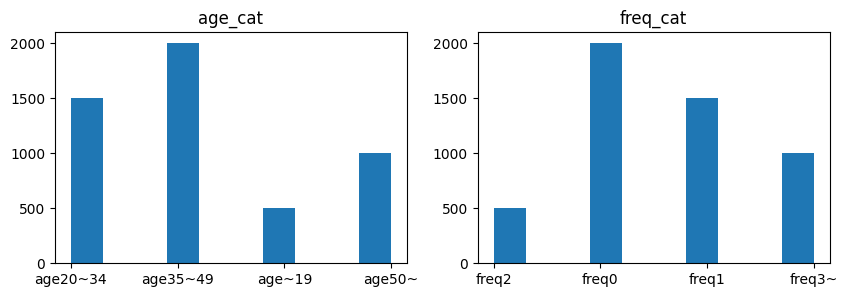

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].hist(customers_df['age_cat'])
axs[0].set_title('age_cat')
axs[1].hist(customers_df['freq_cat'])
axs[1].set_title('freq_cat')
plt.show()

In [28]:
pivot_df = pd.pivot_table(data=customers_df, values='customer_id', columns='freq_cat', index='age_cat', aggfunc='count')
pivot_df = pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
pivot_df

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age~19,200,150,50,100
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200


<Axes: xlabel='freq_cat', ylabel='age_cat'>

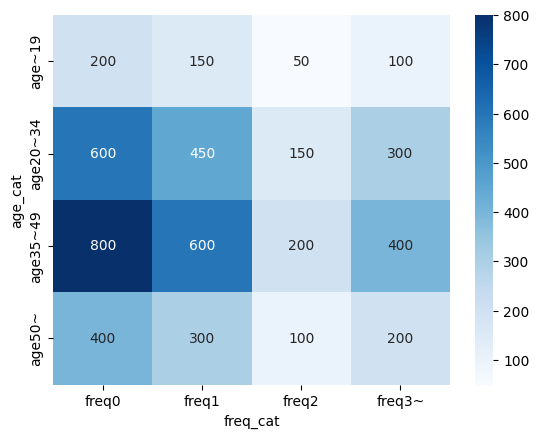

In [33]:
sns.heatmap(pivot_df, annot=True, fmt='d', cmap='Blues')

In [34]:
visit_probability_df

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67
